In [3]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import pandas

In [4]:
def def_cmap(color):
    colors = ["white", color]
    n_bins = 100
    cmap_name = "cmap"
    self_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
    return self_cmap

# Tracking Code for once multiple tracks in the same time interval

In [4]:
with h5py.File("track", "r") as file:
    x_track = file["x_track"][:]
    y_track = file["y_track"][:]
    t_track = file["t_track"][:]

KeyError: "Unable to open object (object 'x_track' doesn't exist)"

In [5]:
# Converting the vector field matrix coordinates into figure coordinates.
x_track_img = (x_track + 1)*16
y_track_img = (y_track + 1)*16

NameError: name 'x_track' is not defined

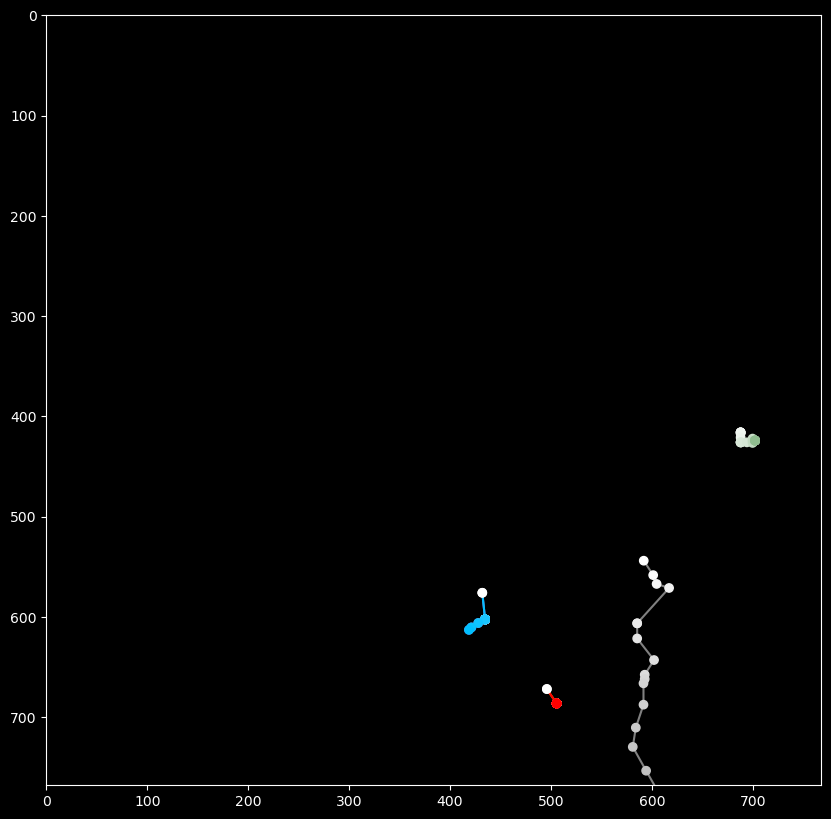

In [6]:
colors = ["gray", "mediumpurple", "deepskyblue", "orange", "red", "darkseagreen", "hotpink", "peru", "olivedrab", "turquoise"]

plt.style.use('dark_background')

fig = plt.figure(figsize=(10, 10))
for i in range(np.shape(x_track)[0]):
    plt.plot(x_track_img[i], y_track_img[i], color=colors[i], zorder=1)
    cmap = def_cmap(colors[i])
    plt.scatter(x_track_img[i], y_track_img[i], c=t_track[:-1], zorder=2, cmap=cmap)
#plt.colorbar(label = "time")
plt.xlim(0, 768)
plt.ylim(0, 768)
plt.gca().invert_yaxis()
plt.show()

# Tracking Code for separate tracking in different time interval

In [3]:
x_track = []
y_track = []
t_track = []

with h5py.File("track", "r") as file:
    track_id = file["track_id"][:]

for i in track_id:
    with h5py.File("track", "r") as file:
        x_track.append(file["x_track_"+str(i)][:])
        y_track.append(file["y_track_"+str(i)][:])
        t_track.append(file["t_track_"+str(i)][:])

## Plot the PIV tracking sample

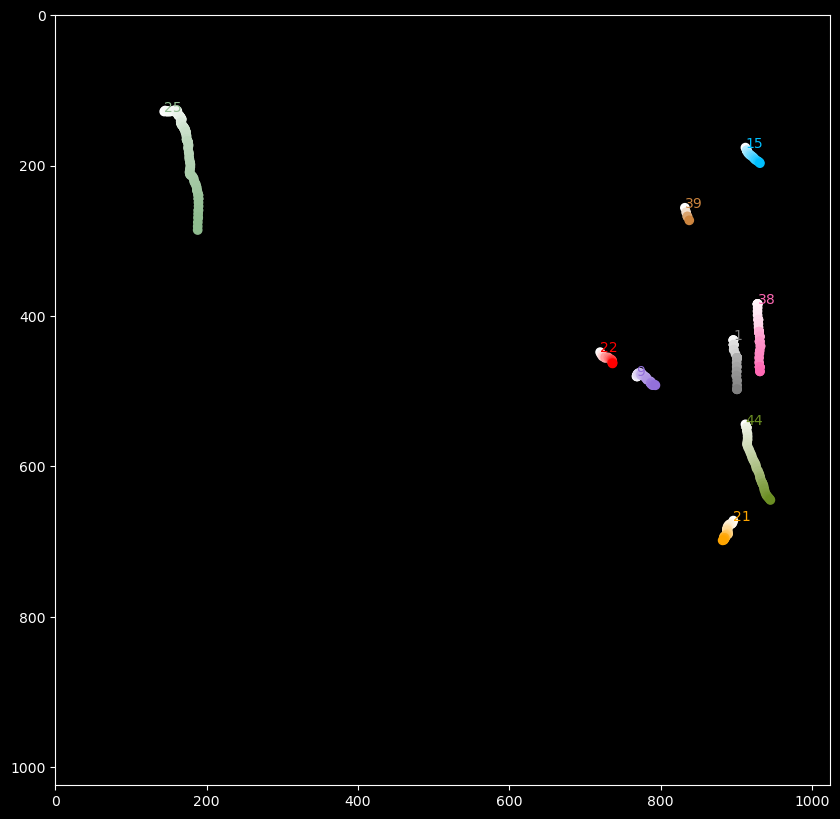

In [4]:
plt.style.use('dark_background')
colors = ["gray", "mediumpurple", "deepskyblue", "orange", "red", "darkseagreen", "hotpink", "peru", "olivedrab", "turquoise"]

piv_x_track = []
piv_y_track = []

plt.figure(figsize=(10, 10))
for i in range(len(track_id)):
    # Convert the track into image coordinates.
    x_cor = (x_track[i] + 1)*16
    y_cor = (y_track[i] + 1)*16
    t_interval = range(t_track[i][0], t_track[i][-1]+1)
    plt.plot(x_cor, y_cor, color=colors[i], zorder=1)
    cmap = def_cmap(colors[i])
    plt.scatter(x_cor, y_cor, c=t_interval, zorder=2, cmap=cmap)
    plt.annotate(str(track_id[i]), xy = (x_cor[0], y_cor[0]), c=colors[i])

    piv_x_track.append(x_cor)
    piv_y_track.append(y_cor)

plt.xlim(0, 1024)
plt.ylim(0, 1024)
plt.gca().invert_yaxis()
#plt.savefig("peseudo_track", dpi=300)
plt.show()

## Plot the original tracking data

In [5]:
# Read csv file.
track_csv = pandas.read_csv("F:/PhD_Franziska/Headon/Headon_results/v1_slice3/video1_tracking_cleaned.csv")

In [6]:
# Extract all starting positions, start frame and end frame of tracks. Build up a new dataframe.

all_track_id = track_csv["Track"].unique().tolist() # List of string.
all_start_x_cor = []
all_start_y_cor = []
all_t = []

for i in all_track_id:
    single_track = track_csv.loc[track_csv["Track"] == i]
    all_start_x_cor.append([single_track.iloc[0]["X"]]) # List of one element lists
    all_start_y_cor.append([single_track.iloc[0]["Y"]]) # list of one element lists
    all_t.append([single_track.iloc[0]["Frame"], single_track.iloc[-1]["Frame"]]) # List of two element lists

# Store the data into h5 files for processing with Julia script.
start_track = h5py.File("start_points.h5", "w")
start_track.create_dataset("track_id", data = all_track_id)
start_track.create_dataset("start_x", data = all_start_x_cor)
start_track.create_dataset("start_y", data = all_start_y_cor)
start_track.create_dataset("t_interval", data = all_t)
start_track.close()

In [48]:
def decode(elem):
    return elem.decode("UTF-8")

with h5py.File("start_points.h5", "r") as file:
    track_id = (list(map(decode, file["track_id"][:])))
    # TODO: further categories reading. 

In [8]:
# Extract certain tracks with given track_ids

original_x_track = []
original_y_track = []
original_t_track = []

for i in track_id:
    o_x = track_csv.loc[track_csv["Track"]==str(i)]["X"].tolist()
    o_y = track_csv.loc[track_csv["Track"]==str(i)]["Y"].tolist()
    o_t = track_csv.loc[track_csv["Track"]==str(i)]["Frame"].tolist()
    original_x_track.append(o_x)
    original_y_track.append(o_y)
    original_t_track.append(o_t)

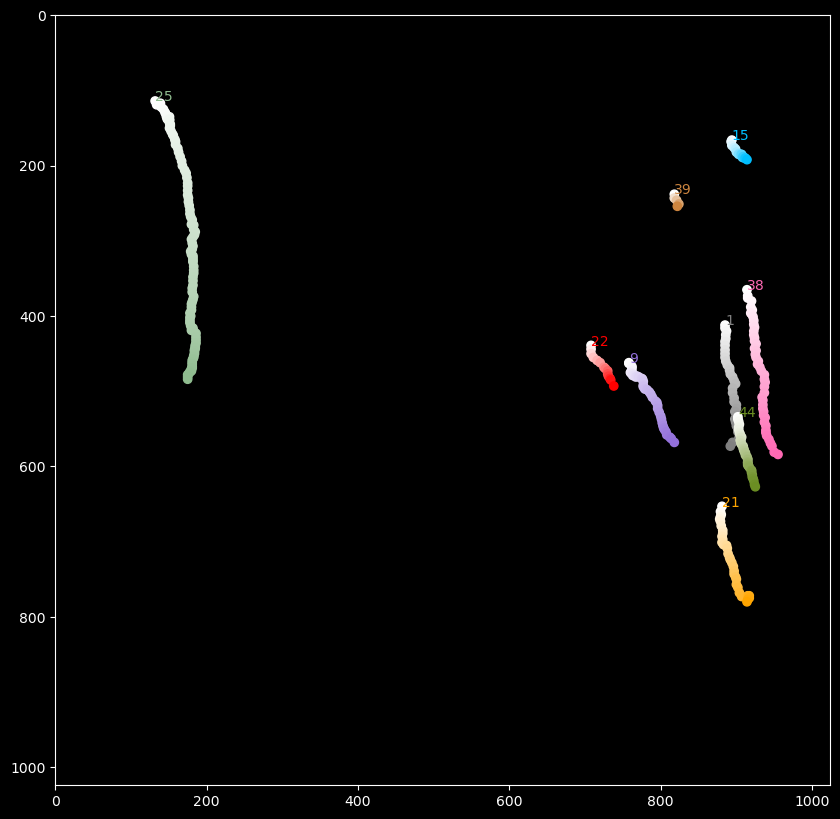

In [9]:
plt.style.use('dark_background')
colors = ["gray", "mediumpurple", "deepskyblue", "orange", "red", "darkseagreen", "hotpink", "peru", "olivedrab", "turquoise"]

plt.figure(figsize=(10, 10))
for i in range(len(track_id)):
    # Convert the track into image coordinates.
    x_cor = original_x_track[i]
    y_cor = original_y_track[i]
    t_interval = original_t_track[i]
    plt.plot(x_cor, y_cor, color=colors[i], zorder=1)
    cmap = def_cmap(colors[i])
    plt.scatter(x_cor, y_cor, c=t_interval, zorder=2, cmap=cmap)
    plt.annotate(str(track_id[i]), xy = (x_cor[0], y_cor[0]), c=colors[i])

plt.xlim(0, 1024)
plt.ylim(0, 1024)
plt.gca().invert_yaxis()
plt.show()

# Error Analysis between original tracking and PIV tracking

In [78]:
mean_error = []
for i in range(len(track_id)):
    
    piv_track_pair = np.dstack((piv_x_track[i], piv_y_track[i])) # Combine two 1D arrays into one 2D arrays. --> (1, n, 2) dimensional.
    original_track_pair = np.dstack((original_x_track[i], original_y_track[i]))
    tim_step = np.shape(piv_track_pair)[1] # Use the number of time points to normalize. The second dimension of piv_track_pair.
    
    error_sum = np.sum(np.linalg.norm(piv_track_pair - original_track_pair, axis=2)) # Sum distance betweeen all points in the same track id.
    
    normal_factor = tim_step*1024
    mean_error.append(error_sum/normal_factor) # Normalize the error by image length/width and time step.
    
print(mean_error)

[0.04317370209849273, 0.02322479541400569, 0.028708011879096478, 0.0372623803232362, 0.021262765388715348, 0.0841844272372936, 0.05277503445430201, 0.025023484077437135, 0.03756429388928593]


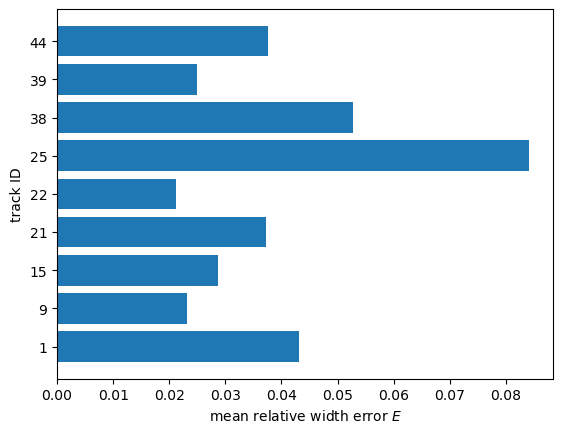

In [101]:
fig, ax = plt.subplots()
track_id_str = track_id.astype(str)
ax.barh(track_id_str, mean_error)
ax.set(xlabel="mean relative width error $E$", ylabel="track ID")
plt.show()